### Code to train a neural network based on our loggerbot's csv output

First we load the log file in csv format.  This assumes our columns are stored in the order exactly as below, and also that there is no contamination (e.g. other print statements) in the csv file:

In [1]:
import pandas as pd
# This assumes we've copied the log file ("LoggerBot.log") into our current working folder...
df0=pd.read_csv("LoggerBot.log",names=["Turn","Try","PlayerID","PlayerName","MissionsBeenOn","FailedMissionsBeenOn","VotedUp0","VotedUp1","VotedUp2","VotedUp3","VotedUp4","VotedUp5","VotedDown0","VotedDown1","VotedDown2","VotedDown3","VotedDown4","VotedDown5","Spy"])

In [2]:
# This next line just prints the first 5 rows of the loaded data, df0, which is a pandas dataframe object
print(df0.head())

   Turn  Try  PlayerID  PlayerName  MissionsBeenOn  FailedMissionsBeenOn  \
0     1    1         0  Trickerton               0                     0   
1     2    1         0  Trickerton               1                     0   
2     3    1         0  Trickerton               2                     0   
3     4    1         0  Trickerton               2                     0   
4     4    2         0  Trickerton               2                     0   

   VotedUp0  VotedUp1  VotedUp2  VotedUp3  VotedUp4  VotedUp5  VotedDown0  \
0         1         0         0         0         0         0           0   
1         2         0         0         0         0         0           0   
2         2         0         0         0         0         0           1   
3         3         0         0         0         0         0           1   
4         3         1         0         0         0         0           1   

   VotedDown1  VotedDown2  VotedDown3  VotedDown4  VotedDown5  Spy  
0          

In [3]:
# Let's take a subset of the data which only corresponds to the player "Bounder", 
# since bounder is hopefully quite representitive of a good player.  This decision to use only one bot
# might not be optimal, but it simplifies things for now.
df=df0.query("PlayerName=='Bounder'") # we can filter a pandas dataframe very nicely like an SQL query!
print(df.head()) #print the filtered dataset

    Turn  Try  PlayerID PlayerName  MissionsBeenOn  FailedMissionsBeenOn  \
20     1    1         4    Bounder               0                     0   
21     2    1         4    Bounder               1                     0   
22     3    1         4    Bounder               2                     0   
23     4    1         4    Bounder               2                     0   
24     4    2         4    Bounder               2                     0   

    VotedUp0  VotedUp1  VotedUp2  VotedUp3  VotedUp4  VotedUp5  VotedDown0  \
20         1         0         0         0         0         0           0   
21         2         0         0         0         0         0           0   
22         2         0         0         0         0         0           1   
23         2         0         0         0         0         0           2   
24         2         1         0         0         0         0           2   

    VotedDown1  VotedDown2  VotedDown3  VotedDown4  VotedDown5  Spy  
20  

In [4]:
print(df.describe()) # print some key column information
# This lets us visually inspect the columns to check there's no nan values in there or infinity values,
# or anything else showing signs of data corruption....

               Turn           Try      PlayerID  MissionsBeenOn  \
count  47755.000000  47755.000000  47755.000000    47755.000000   
mean       2.731735      1.205340      2.010596        0.805068   
std        1.273374      0.538979      1.412544        0.830487   
min        1.000000      1.000000      0.000000        0.000000   
25%        2.000000      1.000000      1.000000        0.000000   
50%        3.000000      1.000000      2.000000        1.000000   
75%        4.000000      1.000000      3.000000        1.000000   
max        5.000000      5.000000      4.000000        4.000000   

       FailedMissionsBeenOn      VotedUp0      VotedUp1      VotedUp2  \
count          47755.000000  47755.000000  47755.000000  47755.000000   
mean               0.490462      1.305036      0.472034      0.223537   
std                0.614432      0.568386      0.640774      0.495715   
min                0.000000      1.000000      0.000000      0.000000   
25%                0.000000    

In [5]:
import numpy as np 
x_train=df.values[:,4:18].astype(np.float32) # This filters out only the columns we want to use as input vector for our NN.
# Note [:,4:18] only includes columns 4 to 17 inclusive (it does not include column 18)
y_train=df.values[:,18].astype(np.int32) # This is our target column.
print(y_train.shape) # This is just a rank 1 array.
print(y_train[0:6]) # first 6 entries of y.  Should be all 1s and zeros
print(x_train[0:6]) # first 6 rows of x, our input vectors.
num_inputs=x_train.shape[1] # this works out how many columns there are in x, i.e. how many inputs our network needs.
num_outputs=2 # Two outputs needed - for "spy" or "not spy".

(47755,)
[0 0 0 0 0 0]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 2. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [2. 0. 2. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [2. 0. 2. 1. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [6]:
# Split the dataset into a training data set and a validation dataset.
dataset_size=len(x_train)
train_set_size=int(dataset_size*0.7) # choose 70% of the data for training and 30% for validation
x_val,y_val=x_train[train_set_size:],y_train[train_set_size:]
x_train,y_train=x_train[:train_set_size],y_train[:train_set_size]

In [7]:
# Build a keras model:
import sys,os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define Sequential model with 3 layers
model = keras.Sequential(name="my_neural_network")
layer1=layers.Dense(10, activation="tanh", input_shape=(num_inputs,))
model.add(layer1)
layer2=layers.Dense(10, activation="tanh")
model.add(layer2)
layer3=layers.Dense(num_outputs, activation="softmax")
model.add(layer3)

print(model(x_train[0:3])) # just check the NN is the correct shape for our training data, and see what comes out of it:

tf.Tensor(
[[0.48127082 0.51872915]
 [0.6231584  0.37684157]
 [0.6198273  0.3801727 ]], shape=(3, 2), dtype=float32)


In [8]:
# Do the usual business for keras training
# It's a classification problem , so we need cross entropy here.
model.compile(
    optimizer=keras.optimizers.Adam(0.001),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [9]:
# Do the usual business for keras training
history = model.fit(
    x_train,
    y_train,
    batch_size=50,
    epochs=120,
    validation_data=(x_val, y_val),verbose=1
)

Epoch 1/120
669/669 [==============================] - 2s 2ms/step - loss: 0.5671 - accuracy: 0.6805 - val_loss: 0.4701 - val_accuracy: 0.7482
Epoch 2/120
669/669 [==============================] - 1s 2ms/step - loss: 0.4657 - accuracy: 0.7431 - val_loss: 0.4557 - val_accuracy: 0.7487
Epoch 3/120
669/669 [==============================] - 1s 2ms/step - loss: 0.4583 - accuracy: 0.7476 - val_loss: 0.4512 - val_accuracy: 0.7542
Epoch 4/120
669/669 [==============================] - 1s 2ms/step - loss: 0.4534 - accuracy: 0.7508 - val_loss: 0.4503 - val_accuracy: 0.7494
Epoch 5/120
669/669 [==============================] - 1s 2ms/step - loss: 0.4502 - accuracy: 0.7528 - val_loss: 0.4483 - val_accuracy: 0.7539
Epoch 6/120
669/669 [==============================] - 1s 2ms/step - loss: 0.4464 - accuracy: 0.7566 - val_loss: 0.4458 - val_accuracy: 0.7595
Epoch 7/120
669/669 [==============================] - 1s 2ms/step - loss: 0.4439 - accuracy: 0.7589 - val_loss: 0.4497 - val_accuracy: 0.7570

KeyboardInterrupt: 

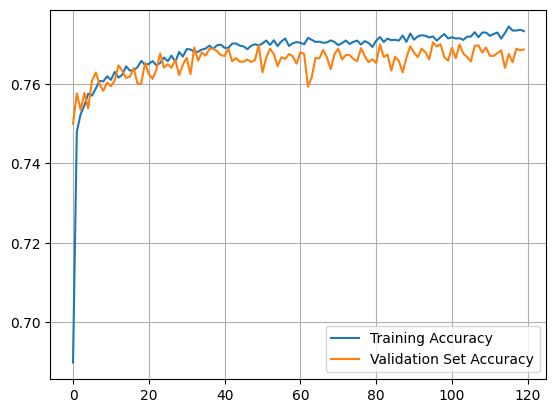

In [10]:
# Plot our training curves. This is always important to see if we've started to overfit or whether 
# we could benefit from more training cycles....
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"],label="Validation Set Accuracy")
plt.legend()
plt.grid()
# The following graph should show about 77% accuracy.

In [11]:
# Calculate base rate accuracy
print(y_train.mean())
# This shows us what accuracy we could get if we just guess the same thing all the time.


0.3907801842766543


- In this game, since there are always 2 spies randomly chosen from a team of 5,  that is 2/5=40% of the time we could guess someone is a spy.  This matches the base rate above, very closely.   

- However if we just wanted a simple fixed classifer to make the best fixed guess, by just saying  "Not Spy" all of the time we could score a whopping 60% accuracy!  So if our classifier can't beat  60% then we can say that it is rubbish.
- Fortunately our classifer is scoring over 70% accuracy comfortably (as should be shown in the graph above).

- In the next code block, I'd like to work out if our neural network's accuracy improves during each game.
- For example, once we've seen several rounds of play we gather more clues as to who is a spy, so our accuracy should increase as each game goes on.

maximum_turn 5
tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int64) [np.float32(0.77227515), np.float32(0.79238683), np.float32(0.8097527), np.float32(0.8222961), np.float32(0.82765573)]


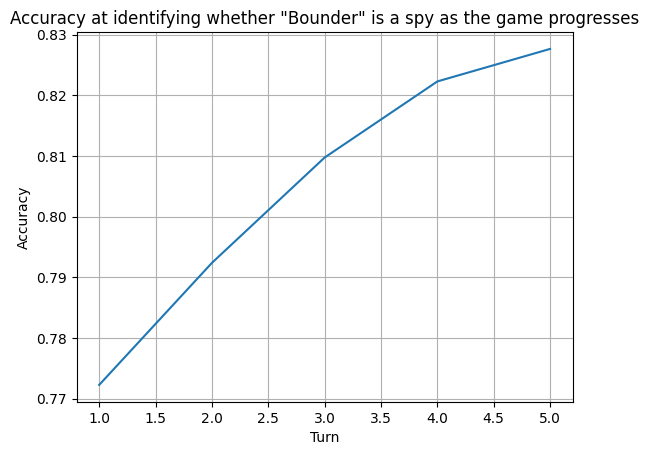

In [12]:
accuracy_by_turn=[]
maximum_turn=df['Turn'].max()
accuracy_metric=tf.keras.metrics.Accuracy()
print("maximum_turn",maximum_turn)
for turn in range(1,maximum_turn+1):
    df_restricted=df.query('Turn>='+str(turn)) # Pull out just those rows of the training data corresponding to later turns in the game
    
    x=df_restricted.values[:,4:18].astype(np.float32)
    y=df_restricted.values[:,18].astype(np.int32)
    y_guess=model(x)
    y_guess=tf.argmax(y_guess,axis=1)
    #accuracy=tf.reduce_mean(tf.cast(tf.equal(y,y_guess),tf.float32)) # This formula owuld also give us the accuracy but this is hand-evaluated.
    accuracy=accuracy_metric(y_guess,y) # This function calculates accuracy using an in-built keras function.
    accuracy_by_turn.append(accuracy.numpy()) # record the results so we can plot them.
print(tf.range(maximum_turn),accuracy_by_turn)
plt.plot(tf.range(1,1+len(accuracy_by_turn)),accuracy_by_turn)
plt.title('Accuracy at identifying whether "Bounder" is a spy as the game progresses')
plt.xlabel('Turn')
plt.ylabel('Accuracy')
plt.grid()

In [13]:
# Finally, save our model so we can build a resistance-bot that plays using this neural network.
model.save('loggerbot_classifier.keras')